In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [ ]:
## income is log-normal distribution
## generate spending distribution percentages by log-normal/inverse log-normal???

In [3]:
tc_score_path = 'tc_score/train.csv'
df = pd.read_csv(tc_score_path)
print(df.shape)
print(df.columns)

(100000, 28)
Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')


/var/folders/rq/l5pq2_mx69j70jc7v9lndv3w0000gn/T/ipykernel_3903/2440272228.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(tc_score_path)


Credit_Score
Good        17.828
Poor        28.998
Standard    53.174
dtype: float64


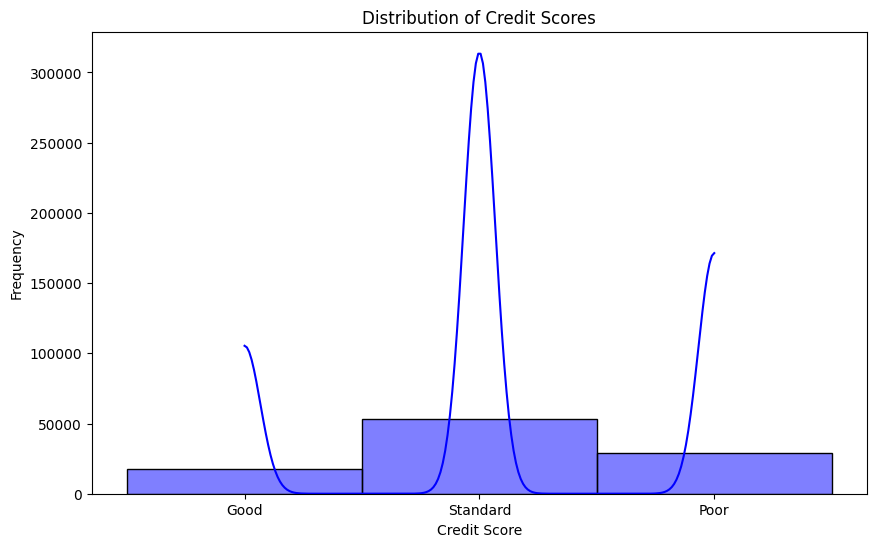

In [12]:
print (100 * df.groupby(['Credit_Score']).size() / len(df.index))
plt.figure(figsize=(10, 6))
sns.histplot(df['Credit_Score'], kde=True, color='blue')
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

In [58]:
# home ownership by income group
## https://www.statista.com/statistics/205440/homeownership-experience-in-the-us-by-income-group/

# if mortage not in df['Type_of_Loan']
#    rent by percentage of gross income +- noise
# standard for utilities (+- noise)

# spending distribution create from xlsx by log-normal??
# and add to 
def get_num_loan(type_of_loan):
    if type(type_of_loan)==float:
        #print(type_of_loan)
        return 0
    if len(type_of_loan)==0:
        return 0
    a = type_of_loan.count(",")
    if a>0:
        return a+1
    return 1

df['Num_of_Loan'] = df['Type_of_Loan'].apply(get_num_loan)
print (100 * df.groupby(['Num_of_Loan']).size() / len(df.index))

def strip_underlines(row):
    if type(row)==str:
        row = row.strip(" _")
    return row

df['Annual_Income'] = df['Annual_Income'].apply(strip_underlines)
print (100 * df.groupby(['Annual_Income']).size() / len(df.index))

np.random.seed(42)

def get_rent(row):
    if type(row['Type_of_Loan'])!=str or "mortage" not in row['Type_of_Loan'].lower():
        BASE_PERCENTAGE = 0.3
        value = float(row['Annual_Income']) / 12 * BASE_PERCENTAGE
        noise = np.random.normal(loc=0, scale=value/5)

        # change to mortage value
        return value + noise
    return 0

df['Rent'] = df.apply(get_rent, axis=1)

def get_utility(rent):
    utility = np.random.normal(loc=0.20, scale=0.04)
    return utility * rent

# df['Utility'] = np.random.uniform(low=200, high=800, size=len(df))
# df['Utility'] = np.random.normal(loc=469, scale=100, size=len(df))
df["Utility"] = df['Rent'].apply(get_utility)


Num_of_Loan
0    11.408
1    11.128
2    15.712
3    15.752
4    15.456
5     7.528
6     8.144
7     7.680
8     3.336
9     3.856
dtype: float64
Annual_Income
10001727.0    0.001
10003.495     0.008
10004.805     0.008
100058.19     0.008
10007.815     0.008
              ...  
99980.36      0.008
99984.48      0.008
9999.42       0.008
99990.78      0.008
99995.22      0.008
Length: 13487, dtype: float64


In [69]:
## spending distribution
## first generate needs number (without rent/utility/mortage)
##     then food at home, food out, transportation, insurances
## next generate wants number

def simulate_food_spending(row):
    total_food_spending = np.random.normal(loc=0.15, scale=0.02) * (float(row['Annual_Income'])/12)  # Assume 15% with some variation

    # Generate a random value for food_needs within the range [0, total_food_spending]
    food_needs_spending = np.random.uniform(0, total_food_spending)

    # Calculate food_wants as the remaining amount
    food_wants_spending = total_food_spending - food_needs_spending

    return food_needs_spending, food_wants_spending

# Apply the function to create new columns for food_needs and food_wants spending
df[['Food_Needs', 'Food_Wants']] = df.apply(simulate_food_spending, axis=1, result_type='expand')


def get_transportation (row):
    transportation_percentage = np.random.normal(loc=0.12, scale=0.02)  # 10% with some variation
    return transportation_percentage * float(row["Annual_Income"]) / 12

df['Transportation'] = df.apply(get_transportation, axis=1)

def get_wants(annual_income):
    ai = float(annual_income)
    wants = np.random.normal(loc=0.25, scale=0.02)
    return wants * ai / 12

df['Wants'] = df['Annual_Income'].apply(get_wants)

def get_savings(row):
    total = float(row["Annual_Income"]) / 12
    total -= row["Rent"] + row["Utility"] + row["Food_Needs"] + row['Food_Wants'] + row["Transportation"] + row['Total_EMI_per_month'] + row['Wants']
    return total

def get_need_perc(row):
    return (row["Rent"] + row["Utility"] + row["Food_Needs"] + row["Transportation"] + row['Total_EMI_per_month']) /(float(row['Annual_Income'])/12)

def get_want_perc(row):
    return (row['Wants'] + row['Food_Wants'])/(float(row['Annual_Income'])/12)

def get_saving_perc(row):
    return row['Savings']/(float(row['Annual_Income'])/12)

df['Savings'] = df.apply(get_savings, axis=1)
df['Need_Percent'] = df.apply(get_need_perc, axis=1)
df['Want_Percent'] = df.apply(get_want_perc, axis=1)
df['Saving_Percent'] = df.apply(get_saving_perc, axis=1)

def needs_deviation(need_perc):
    return (need_perc-.5)**2

def want_deviation(want_perc):
    return (want_perc-.3)**2

def saving_deviation(saving_perc):
    return (saving_perc-.2)**2

df["Need_Deviation"] = df['Need_Percent'].apply(needs_deviation)
df["Want_Deviation"] = df['Want_Percent'].apply(want_deviation)
df["Saving_Deviation"] = df["Saving_Percent"].apply(saving_deviation)

def total_deviation(row):
    return math.sqrt(row["Need_Deviation"]**2 + row["Want_Deviation"]**2 + row["Saving_Deviation"]**2)

df["Total_Deviation"] = df.apply(total_deviation, axis=1)

In [70]:
print(df.head(5))
df.to_csv("generated.csv", index=False)

       ID Customer_ID     Month           Name   Age          SSN Occupation  \
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist   
1  0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265  Scientist   
2  0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265  Scientist   
3  0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265  Scientist   
4  0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265  Scientist   

  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \
0      19114.12            1824.843333                  3  ...   
1      19114.12                    NaN                  3  ...   
2      19114.12                    NaN                  3  ...   
3      19114.12                    NaN                  3  ...   
4      19114.12            1824.843333                  3  ...   

   Transportation       Wants     Savings Need_Percent  Want_Percent  \
0      148.216888  378.767740  156.783039     0.61